In [47]:
# %load VAE_depth.py
#This is VAE_depth script 
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)
tf.set_random_seed(0)
config=tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.4
tf.reset_default_graph()


# Initialization Function
def xavier_init(fan_in, fan_out, constant=1): 
    """ Xavier initialization of network weights"""
    # https://stackoverflow.com/questions/33640581/how-to-do-xavier-initialization-on-tensorflow
    low = -constant*np.sqrt(6.0/(fan_in + fan_out)) 
    high = constant*np.sqrt(6.0/(fan_in + fan_out))
    # return tensors
    return tf.random_uniform((fan_in, fan_out), #  shape of the weights
                             minval=low, maxval=high, # here is the range 
                             dtype=tf.float32) # here is the type 

# Variational Auto Encoder 
class VariationalAutoencoder(object):
    
    """ Based on See "Auto-Encoding Variational Bayes" by Kingma and Welling
    """
    def __init__(self, network_architecture,
                 transfer_fct=tf.nn.relu,learning_rate=1e-3,batch_size=100):
        
        
        self.network_architecture=network_architecture# which is a dictionary 
        self.transfer_fct=transfer_fct
        self.learning_rate=learning_rate
        self.batch_size=batch_size
        # tf Graph input
        self.x=tf.placeholder(tf.float32,[None, network_architecture["n_input"]])
        self.mask=tf.placeholder(tf.float32,[None, network_architecture["n_input"]])
        # Create auotencoder 
        self.create_network()
        # define loss function based on variational upper bound 
        # and corresponding optimizer 
        self.create_loss_optimizer()
        # initial the tensorflow variables 
        init=tf.global_variables_initializer()
        self.saver_d=tf.train.Saver()
        self.sess=tf.Session(config=config)
        self.sess.run(init)
    
    
            
    def initialize_weights(self, n_hidden_recog_1, n_hidden_recog_2, 
                            n_hidden_gener_1,  n_hidden_gener_2, 
                            n_input, n_z):
        
        # create a dictionary of tensor variables 
        all_weights = dict()
        # recognition  network
        all_weights['weights_recog'] = {
            'h1': tf.Variable(xavier_init(n_input, n_hidden_recog_1)),
            'h2': tf.Variable(xavier_init(n_hidden_recog_1, n_hidden_recog_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_recog_2, n_z)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_recog_2, n_z))}
        all_weights['biases_recog'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_recog_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_recog_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_z], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_z], dtype=tf.float32))}
        
        # generate network 
        all_weights['weights_gener'] = {
            'h1': tf.Variable(xavier_init(n_z, n_hidden_gener_1)),
            'h2': tf.Variable(xavier_init(n_hidden_gener_1, n_hidden_gener_2)),
            'out_mean': tf.Variable(xavier_init(n_hidden_gener_2, n_input)),
            'out_log_sigma': tf.Variable(xavier_init(n_hidden_gener_2, n_input))}
        all_weights['biases_gener'] = {
            'b1': tf.Variable(tf.zeros([n_hidden_gener_1], dtype=tf.float32)),
            'b2': tf.Variable(tf.zeros([n_hidden_gener_2], dtype=tf.float32)),
            'out_mean': tf.Variable(tf.zeros([n_input], dtype=tf.float32)),
            'out_log_sigma': tf.Variable(tf.zeros([n_input], dtype=tf.float32))}
        return all_weights
    
    def create_network(self):
        # create tensor variables for  weights and bias
        network_weights=self.initialize_weights(**self.network_architecture) 
        # pass architecture parameters 
        # network_architecture is a dictionary 
        
        
        # recognition network :
        #input: data x shape [batch_size,n_x]
        #output : mean of z , log(variance^2) shape [batch_size,n_z]
        # pass variables to network 
        self.z_mean, self.z_log_sigma_sq = \
            self.recognition_network(network_weights["weights_recog"], 
                                     network_weights["biases_recog"])
            
        n_z = self.network_architecture["n_z"]# dimension of z
        
        
        eps = tf.random_normal((self.batch_size, n_z), 0, 1, dtype=tf.float32) 
        # standard Normal
        # z = z_mean + z_sigma*epsilon
        self.z = tf.add(self.z_mean, tf.multiply(tf.sqrt(tf.exp(self.z_log_sigma_sq)), eps))
        #shape [batch_size,n_z]
        
        # Generate network :
        # input z
        # output mean of pixels shape[batch_Size,n_x]
        # multivariant Gaussian Distribution
        self.x_reconstr_mean = \
            self.generator_network(network_weights["weights_gener"],
                                   network_weights["biases_gener"])
    
    def recognition_network(self, weights, biases):
        # Generate probabilistic encoder (recognition network), which
        # maps inputs onto a normal distribution in latent space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.x, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        z_mean = tf.add(tf.matmul(layer_2, weights['out_mean']),
                        biases['out_mean'])
        
        z_log_sigma_sq =\
            tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
                   biases['out_log_sigma'])
            
        return (z_mean, z_log_sigma_sq)
    
    # use variables to buld generate network 
    def generator_network(self, weights, biases):
        # Generate probabilistic decoder (decoder network), which
        # maps points in latent space onto a Bernoulli distribution in data space.
        # The transformation is parametrized and can be learned.
        layer_1 = self.transfer_fct(tf.add(tf.matmul(self.z, weights['h1']), 
                                           biases['b1'])) 
        layer_2 = self.transfer_fct(tf.add(tf.matmul(layer_1, weights['h2']), 
                                           biases['b2'])) 
        
        # depth estimation mean 
        x_reconstr_mean = \
           tf.nn.relu(tf.add(tf.matmul(layer_2, weights['out_mean']), 
                                 biases['out_mean']))
            
        #x_reconstr_sigma= \
        #     tf.add(tf.matmul(layer_2, weights['out_log_sigma']), 
        #                        biases['out_log_sigma'])
            
        return x_reconstr_mean
    
    def create_loss_optimizer(self):
        # The loss is composed of two terms:
        
        # 1.) The reconstruction loss (the negative log probability
        #     of the input under the reconstructed Bernoulli/Gaussian distribution 
        #     induced by the decoder in the data space).
        #     This can be interpreted as the number of "nats" required
        #     for reconstructing the input when the activation in latent
        #     is given.
        # Adding 1e-10 to avoid evaluation of log(0.0)
        # Assuem identity gaussian 
        
        # loss from generative data 
        
        # 1) bernouli distribution
        """
        reconstr_loss =-tf.reduce_sum(self.x * tf.log(1e-10 + self.x_reconstr_mean)
                           + (1-self.x) * tf.log(1e-10 + 1 - self.x_reconstr_mean),
                           axis=1)
        """
        # 1) gaussian distribution
        reconstr_error=(self.x-self.x_reconstr_mean)*self.mask
        reconstr_loss=tf.reduce_sum(tf.square(reconstr_error),axis=1)
          
        # 2.) The latent loss, which is defined as the Kullback Leibler divergence 
        ##    between the distribution in latent space induced by the encoder on 
        #     the data and some prior. This acts as a kind of regularizer.
        #     This can be interpreted as the number of "nats" required
        #     for transmitting the the latent space distribution given
        #     the prior.
        #     closed form of  KL  divergence with gaussian distribution
        latent_loss=-0.5*tf.reduce_sum(1+self.z_log_sigma_sq 
                                           -tf.square(self.z_mean) 
                                           -tf.exp(self.z_log_sigma_sq), axis=1)
        
        self.cost = tf.reduce_mean(reconstr_loss + latent_loss) # average over batch
        # Use ADAM optimizer
        
        self.optimizer = \
            tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.cost)
        
    def partial_fit(self, X):
        """Train model based on mini-batch of input data.
        
        Return cost of mini-batch.
        """
        opt, cost = self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x: X})
        return cost
    def transform(self, X):
        """Transform data by mapping it into the latent space."""
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.z_mean, feed_dict={self.x: X})
    def generate(self, z_mu=None):
        """ Generate data by sampling from latent space.
        
        If z_mu is not None, data for this point in latent space is
        generated. Otherwise, z_mu is drawn from prior in latent 
        space.        
        """
        if z_mu is None:
            z_mu = np.random.normal(size=self.network_architecture["n_z"])
        # Note: This maps to mean of distribution, we could alternatively
        # sample from Gaussian distribution
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.z: z_mu})
    def reconstruct(self, X):
        """ Use VAE to reconstruct given data. """
        return self.sess.run(self.x_reconstr_mean, 
                             feed_dict={self.x: X})
    
    def save(self, check_point_file = 'model.ckpt'):
        save_path = self.saver_d.save(self.sess, check_point_file) # Saves the weights (not the graph)
        print("saved the vae model weights to "+save_path)
        # to load it,
        
    def load(self, check_point_file = 'model.ckpt'):
        self.saver_d.restore(self.sess, check_point_file)
        print("loaded model weights from "+check_point_file)
        
    def train(self, batch_size=100,training_epochs=1,display_step=1):
        print("training started ...")
        train_indices=range(n_samples)
        
        for epoch in range(training_epochs):
            avg_cost = 0.
            total_batch = int(n_samples / batch_size)
            perm_indices=np.random.permutation(train_indices)
        # Loop over all batches
            for i in range(total_batch):
                
                offset=(i*batch_size)%(n_samples-batch_size)
                # mnist data  batch_xs, _ = mnist.train.next_batch(batch_size)
                batch_indices=perm_indices[offset:(offset+batch_size)]
                
                batch_xs=Depth_input[batch_indices]
                batch_mask=Depthmask_input[batch_indices]
            # Fit training using batch data
                _,cost=self.sess.run((self.optimizer, self.cost), 
                                  feed_dict={self.x:batch_xs,self.mask:batch_mask})
              
            # Compute average loss
                avg_cost += cost / n_samples * batch_size
        # Display logs per epoch step
            if epoch % display_step == 0:
                print("Epoch:", '%04d' % (epoch+1), 
                      "cost=", "{:.9f}".format(avg_cost))


# Load depth data 
depth_data=np.load("../Data/depth_data.npy")
depthmask_data=np.load("../Data/depth_mask.npy")
Depth_input=depth_data[:,:,:,0].reshape(-1,1080)
Depthmask_input=depthmask_data[:,:,:,0].reshape(-1,1080)
#Depth_input=np.transpose(depth_data,(0,2,1,3))[:,:,:,0].reshape(-1,1080)
n_samples=Depth_input.shape[0]


with tf.variable_scope("depth"):
    network_architecture = \
        dict(n_hidden_recog_1=1000, # 1st layer encoder neurons
         n_hidden_recog_2=1000, # 2nd layer encoder neurons
         n_hidden_gener_1=1000, # 1st layer decoder neurons
         n_hidden_gener_2=1000, # 2nd layer decoder neurons
         n_input=1080, # MNIST data input (img shape: 28*28)
         n_z=50)  # dimensionality of latent space
    vae = VariationalAutoencoder(network_architecture,learning_rate=1e-3,batch_size=100)


train_new_model =True
if train_new_model:    
    vae.train(batch_size=100,training_epochs=10)
    vae.save("vae_models/depth_1_epochs/model")
else:
    vae.load("vae_models/depth_1_epochs/model")

training started ...
Epoch: 0001 cost= 32.855397269
Epoch: 0002 cost= 32.468953596
Epoch: 0003 cost= 32.398050426
Epoch: 0004 cost= 32.352658900
Epoch: 0005 cost= 32.280002741
Epoch: 0006 cost= 32.252218595
Epoch: 0007 cost= 32.189153268
Epoch: 0008 cost= 32.144255458
Epoch: 0009 cost= 32.115303418
Epoch: 0010 cost= 32.069611579
saved the vae model weights to vae_models/depth_1_epochs/model


In [41]:
Depth_input[0]

array([-0.        ,  0.05544548,  0.05381951, ...,  0.18291567,
        0.18345258,  0.17574692])

In [49]:
%matplotlib inline
prediction=vae.sess.run(vae.x_reconstr_mean,feed_dict={vae.x:Depth_input[0:100,:]})

In [50]:
prediction[0]

array([0.        , 0.        , 0.        , ..., 0.18057153, 0.17727605,
       0.17322063], dtype=float32)

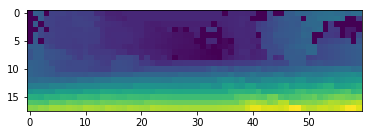

In [51]:
plt.imshow(Depth_input[0].reshape(18,60))

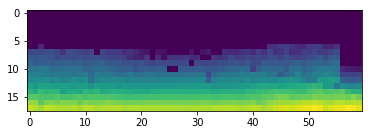

In [52]:
plt.imshow(prediction[0].reshape(18,60))

In [54]:
vae.sess.close()